<a href="https://colab.research.google.com/github/willian-silva01/IA/blob/main/GridSearch%20e%20KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estatísticas Descritivas:
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0

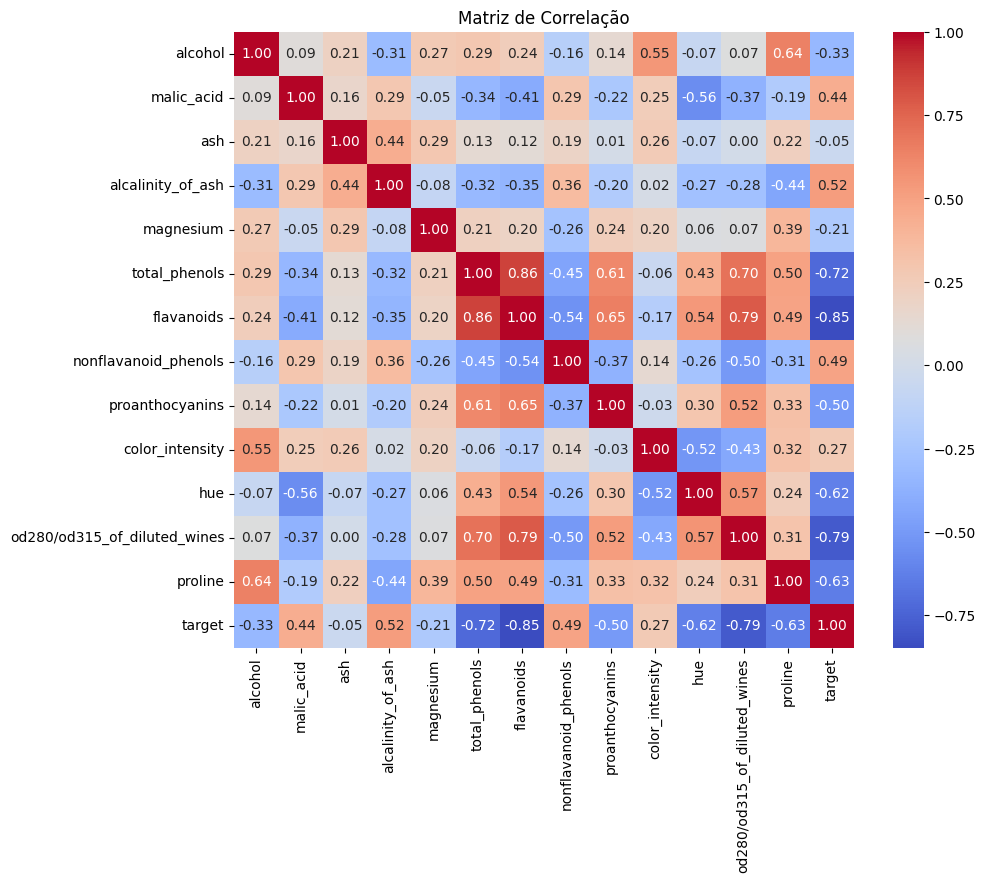


=== Decision Tree ===
Melhores parâmetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.88      1.00      0.93        14
           2       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.96      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



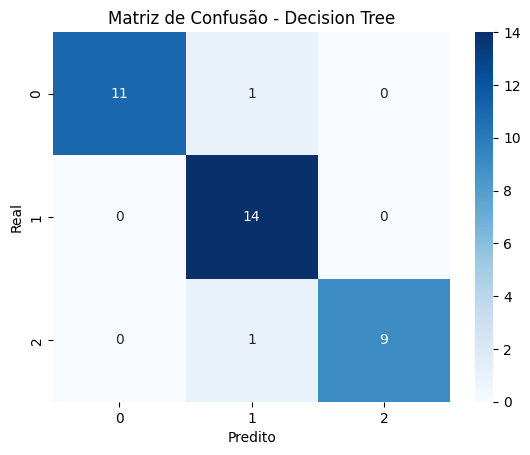


=== KNN ===
Melhores parâmetros: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



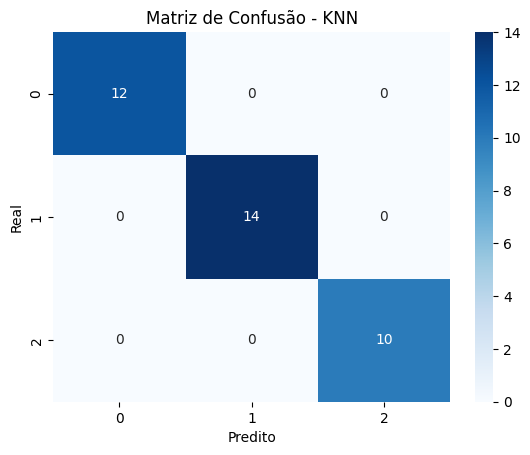


=== Naive Bayes ===
Melhores parâmetros: {'var_smoothing': np.float64(1e-11)}
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



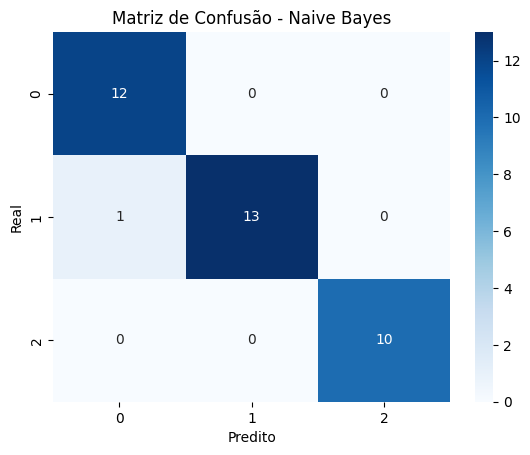

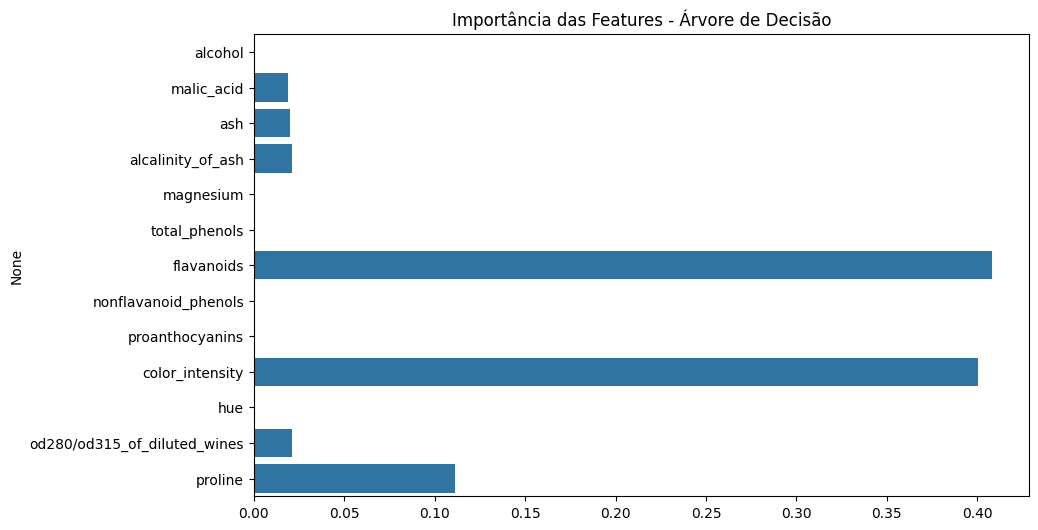

In [5]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Carregar e explorar o dataset ===
wine = load_wine(as_frame=True)
df = wine.frame

# Exibir estatísticas descritivas
print("Estatísticas Descritivas:")
print(df.describe())

# Verificar se há valores nulos
print("\nValores nulos por coluna:")
print(df.isnull().sum())

# Distribuição das classes
print("\nDistribuição das classes (target):")
print(df['target'].value_counts())

# Correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

# Separar features e target
X = df.drop('target', axis=1)
y = df['target']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Configurar KFold com 4 divisões
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

# === 2. Modelos e parâmetros para GridSearch ===

# 1. Árvore de Decisão
tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
tree_clf = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=kfold, scoring='accuracy')
tree_clf.fit(X_train, y_train)

# 2. KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidiana
}
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_params, cv=kfold, scoring='accuracy')
knn_clf.fit(X_train_scaled, y_train)

# 3. Naive Bayes
nb_params = {
    'var_smoothing': np.logspace(-11, -7, 5)
}
nb_clf = GridSearchCV(GaussianNB(), nb_params, cv=kfold, scoring='accuracy')
nb_clf.fit(X_train_scaled, y_train)

# === 3. Avaliação dos modelos ===

models = {
    "Decision Tree": tree_clf,
    "KNN": knn_clf,
    "Naive Bayes": nb_clf
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    print("Melhores parâmetros:", model.best_params_)
    y_pred = model.predict(X_test_scaled if name != "Decision Tree" else X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Matriz de Confusão - {name}')
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

# Importância das features da árvore de decisão
importances = tree_clf.best_estimator_.feature_importances_
feat_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feat_names)
plt.title("Importância das Features - Árvore de Decisão")
plt.show()
